<a href="https://colab.research.google.com/github/mateollorente/Producto/blob/master/VectorMeEncanto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
from google.colab import userdata
import os, json
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from scipy.signal import medfilt
import os

In [ ]:


kaggle_username = userdata.get("kaggle_username")
kaggle_key = userdata.get("kaggle_key")

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

!pip install kaggle --quiet
!kaggle datasets download -d evilspirit05/ecg-analysis -p ./data --unzip

Dataset URL: https://www.kaggle.com/datasets/evilspirit05/ecg-analysis
License(s): MIT
 92% 763M/826M [00:04<00:01, 42.6MB/s]
100% 826M/826M [00:04<00:00, 203MB/s] 


In [ ]:
# --- 1. Tu función de carga (Modificada para no 'morir' en un error) ---
def load_image_rgb(path):
    """
    Carga la imagen, la pasa a gris y aplica un umbral fijo (50).
    Devuelve una imagen 2D binarizada (Blanco y Negro).
    """
    img = cv2.imread(path)
    try:
        if img is None:
            print(f"Error: No se pudo cargar la imagen: {path}")
            return None # Devolver None en lugar de 'exit()'

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        umbral = 50
        ret, img_limpia = cv2.threshold(gray, umbral, 255, cv2.THRESH_BINARY)

    except Exception as e:
        print(f"Ocurrió un error en load_image_rgb con {path}: {e}")
        return None

    return img_limpia # Devuelve la imagen 2D B&W

In [ ]:
def kmeans_1d_weighted(indices, weights, k=3, max_iter=100, tol=1e-3):
    """K-Means 1D ponderado para encontrar centros de proyección."""
    idx_min, idx_max = indices.min(), indices.max()
    centers = np.linspace(idx_min, idx_max, k)
    for it in range(max_iter):
        dists = np.abs(indices.reshape(-1,1) - centers.reshape(1,-1))
        labels = dists.argmin(axis=1)
        new_centers = np.zeros_like(centers)
        for j in range(k):
            mask = labels == j
            if not np.any(mask):
                new_centers[j] = centers[j]
            else:
                w = weights[mask]
                idxs = indices[mask]
                new_centers[j] = np.sum(idxs * w) / (np.sum(w) + 1e-9)
        shift = np.max(np.abs(new_centers - centers))
        centers = new_centers
        if shift < tol:
            break
    return np.sort(centers)

In [ ]:
def resize_vector(v, target_len):
    """Redimensiona un vector 1D a una longitud objetivo."""
    if len(v) == target_len:
        return v.copy()
    x_old = np.linspace(0, 1, len(v))
    x_new = np.linspace(0, 1, target_len)
    return np.interp(x_new, x_old, v).astype(np.float32)

In [ ]:
def extract_roi_from_bw(img_bw, min_area=1000):
    """
    Detecta el borde (ROI) basándose en los contornos de la imagen binarizada.
    """
    if img_bw is None:
        return None
    h, w = img_bw.shape
    inverted_img = 255 - img_bw
    contours, _ = cv2.findContours(inverted_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img_bw
    big_contour = max(contours, key=cv2.contourArea)
    if cv2.contourArea(big_contour) < min_area:
        return img_bw
    x, y, w_roi, h_roi = cv2.boundingRect(big_contour)
    roi_bw = img_bw[y:y+h_roi, x:x+w_roi]
    return roi_bw

In [ ]:
def split_bw_image_by_projection(roi_bw, num_parts=3):
    """
    Divide el ROI binarizado en 3 partes usando proyección horizontal.
    """
    h, w = roi_bw.shape
    inverted_img = 255 - roi_bw
    proj = inverted_img.sum(axis=1).astype(float)

    if proj.max() == 0: # Fallback
        parts = []
        part_height = h // num_parts
        for i in range(num_parts):
            start = i * part_height
            end = (i + 1) * part_height if i < num_parts - 1 else h
            parts.append(roi_bw[start:end, :])
        return parts

    rows = np.arange(len(proj))
    weights = proj / (proj.max() + 1e-9)
    centers = kmeans_1d_weighted(rows, weights, k=num_parts)
    centers = np.array(centers)
    cuts = []
    for i in range(len(centers)-1):
        cuts.append(int(round((centers[i] + centers[i+1]) / 2.0)))

    parts = []
    start = 0
    for c in cuts:
        parts.append(roi_bw[start:c, :])
        start = c
    parts.append(roi_bw[start:h, :])
    return parts

In [ ]:
def part_to_vector_simple(part_bw):
    """
    Convierte una parte binarizada (B&W) en un vector 1D.
    """
    h, w = part_bw.shape
    if h == 0 or w == 0:
        return np.array([], dtype=float)
    ys = np.zeros(w, dtype=float)
    for col in range(w):
        rows_on = np.where(part_bw[:, col] == 0)[0] # Señal es negra (0)
        if rows_on.size > 0:
            ys[col] = np.median(rows_on)
        else:
            ys[col] = np.nan
    nans = np.isnan(ys)
    if nans.all():
        ys[:] = h / 2.0
    elif nans.any():
        not_nan = ~nans
        x_indices = np.arange(w)
        ys[nans] = np.interp(x_indices[nans], x_indices[not_nan], ys[not_nan])
    ys = (h - 1) - ys
    return ys

In [ ]:
def ecg_bw_photo_to_vector(path, target_len=2048, num_parts=3):
    """
    Función de pipeline final y limpia.
    Toma la ruta de una imagen, la procesa con el pipeline B&W
    y devuelve el vector final.
    """
    # 1. Cargar (con tu función)
    img_bw = load_image_rgb(path)
    if img_bw is None:
        # Si la carga falla, devuelve None para que puedas omitirlo
        return None

    # 2. Detectar Borde (ROI)
    roi_bw = extract_roi_from_bw(img_bw)
    if roi_bw is None:
        return None # Omitir si no hay ROI

    # 3. Dividir por Proporciones
    parts = split_bw_image_by_projection(roi_bw, num_parts)

    centered_vectors = []

    # 4. Vectorizar cada parte
    for p in parts:
        vec = part_to_vector_simple(p)
        if vec.size == 0:
            continue

        baseline = np.nanmedian(vec)
        if not np.isnan(baseline):
            vec_centered = vec - baseline
        else:
            vec_centered = vec

        centered_vectors.append(vec_centered)

    if not centered_vectors:
        return None # Omitir si no se pudo vectorizar

    # 5. Concatenar
    full = np.concatenate(centered_vectors)

    # 6. Normalizar y Filtrar
    mn, mx = np.nanmin(full), np.nanmax(full)
    if mx - mn > 1e-6:
        full = (full - mn) / (mx - mn)
    else:
        full = np.full_like(full, 0.5)

    # Filtro mediano suave (el corregido)
    full = medfilt(full, kernel_size=3)

    # 7. Redimensionar
    final = resize_vector(full, target_len)

    return final

In [ ]:
!git clone https://github.com/SantiagoBuffa/BeatAI.git
%cd BeatAI

Cloning into 'BeatAI'...
remote: Enumerating objects: 1111, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 1111 (delta 52), reused 67 (delta 29), pack-reused 1010 (from 1)
Receiving objects: 100% (1111/1111), 108.07 MiB | 21.15 MiB/s, done.
Resolving deltas: 100% (731/731), done.
/content/BeatAI


In [ ]:
def show_vector_simple(path, visualize_steps=False):
    """
    Función de ayuda para ejecutar el pipeline y mostrar el resultado.
    """
    final_vector = ecg_bw_photo_to_vector(path, target_len=2048)

    plt.figure(figsize=(30,3))
    plt.plot(final_vector)
    plt.title("Vector Final (Pipeline Simple B&W con Filtro Corregido)")
    plt.grid(True)
    plt.show()
    return final_vector

Error: No se pudo cargar la imagen: /content/hi.jpeg


ValueError: x, y, and format string must not be None

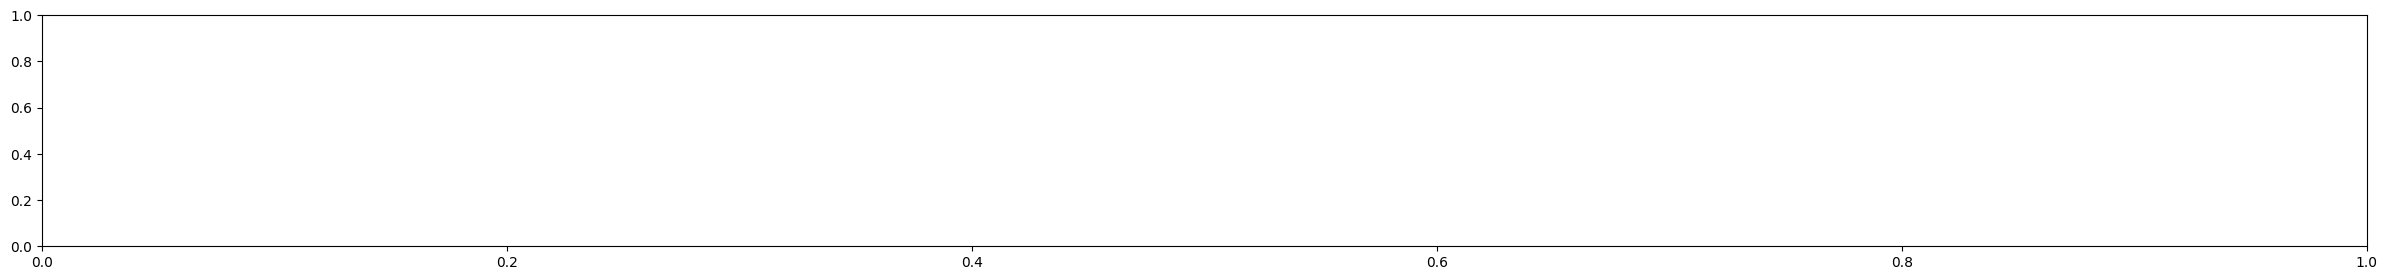

In [ ]:
show_vector_simple("/content/hi.jpeg",visualize_steps=True);

In [ ]:
def preprocess_dataset_1d(dataset_path, target_len=2048, num_rows=4):

    #Carga todas las imágenes del dataset y genera vectores 1D concatenados.

    train_dir = os.path.join(dataset_path, 'train')
    test_dir = os.path.join(dataset_path, 'test')

    X_train, y_train = [], []
    X_test, y_test = [], []

    class_names = sorted(os.listdir(train_dir))
    print(f"📂 Clases detectadas: {class_names}")

    # --- TRAIN ---
    for label, cls in enumerate(class_names):
        cls_dir = os.path.join(train_dir, cls)
        for fname in tqdm(os.listdir(cls_dir), desc=f"Procesando {cls} (train)"):
            path = os.path.join(cls_dir, fname)
            if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            vec = ecg_bw_photo_to_vector(path, target_len)

            X_train.append(vec)
            y_train.append(label)

    # --- TEST ---
    for label, cls in enumerate(class_names):
        cls_dir = os.path.join(test_dir, cls)
        for fname in tqdm(os.listdir(cls_dir), desc=f"Procesando {cls} (test)"):
            path = os.path.join(cls_dir, fname)
            if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            vec = ecg_bw_photo_to_vector(path, target_len)

            if vec is None:
                continue
            X_test.append(vec)
            y_test.append(label)

    X_train = np.array(X_train)[..., np.newaxis]
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(class_names))
    X_test = np.array(X_test)[..., np.newaxis]
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(class_names))

    # --- VALIDATION ---
    # X_val se creará a partir de X_train.
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train.argmax(axis=1)
    )

    print(f"✅ X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
def build_ecg_1d_model(input_length=2048, num_classes=4):

    #Construye el modelo CNN 1D
    model = models.Sequential([
        layers.Input(shape=(input_length,)),
        # Reshape para añadir el canal (necesario para Conv1D)
        layers.Reshape((input_length, 1)),

        layers.Conv1D(64, 20, activation='relu', padding='same'),
        layers.MaxPooling1D(2),

        layers.Conv1D(128, 10, activation='relu', padding='same'),
        layers.MaxPooling1D(2),

        layers.Conv1D(256, 5, activation='relu', padding='same'),
        layers.GlobalAveragePooling1D(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
dataset_path = "/content/data/ECG_DATA"
TARGET_VECTOR_LENGTH = 2048
NUM_CLASSES = 4


X_train, y_train, X_val, y_val, X_test, y_test = preprocess_dataset_1d(
    dataset_path
)




📂 Clases detectadas: ['ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'Normal Person ECG Images (284x12=3408)']


Procesando ECG Images of Myocardial Infarction Patients (240x12=2880) (train): 100%|██████████| 956/956 [02:51<00:00,  5.56it/s]
Procesando ECG Images of Patient that have History of MI (172x12=2064) (train): 100%|██████████| 516/516 [01:31<00:00,  5.61it/s]
Procesando ECG Images of Patient that have abnormal heartbeat (233x12=2796) (train): 100%|██████████| 699/699 [02:04<00:00,  5.63it/s]
Procesando Normal Person ECG Images (284x12=3408) (train): 100%|██████████| 852/852 [02:32<00:00,  5.58it/s]
Procesando ECG Images of Myocardial Infarction Patients (240x12=2880) (test): 100%|██████████| 239/239 [00:42<00:00,  5.57it/s]
Procesando ECG Images of Patient that have History of MI (172x12=2064) (test): 100%|██████████| 172/172 [00:31<00:00,  5.46it/s]
Procesando ECG Images of Patient that have abnormal heartbeat (233x12=2796) (test): 100%|██████████| 233/233 [00:41<00:00,  5.58it/s]
Procesando Normal Person ECG Images (284x12=3408) (test): 100%|██████████| 284/284 [00:50<00:00,  5.62it/s

✅ X_train: (2418, 2048, 1), X_val: (605, 2048, 1), X_test: (928, 2048, 1)


In [ ]:
# Construir el modelo
model = build_ecg_1d_model(
    input_length=TARGET_VECTOR_LENGTH,
    num_classes=NUM_CLASSES
)



In [ ]:
model.summary()

print("\nIniciando entrenamiento...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)]
)

# Evaluar en el conjunto de test (limpio)
print("\nEvaluando en el conjunto de test (limpio)...")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2048, 64)       │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1024, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 512, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 512, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,900 (1.07 MB)

 Trainable params: 280,900 (1.07 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento...
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 59s 751ms/step - accuracy: 0.2961 - loss: 1.3746 - val_accuracy: 0.3157 - val_loss: 1.3365
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 740ms/step - accuracy: 0.3691 - loss: 1.3127 - val_accuracy: 0.4033 - val_loss: 1.2434
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 744ms/step - accuracy: 0.4126 - loss: 1.2444 - val_accuracy: 0.4628 - val_loss: 1.1571
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 80s 721ms/step - accuracy: 0.4868 - loss: 1.1422 - val_accuracy: 0.5438 - val_loss: 1.0741
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 54s 712ms/step - accuracy: 0.5050 - loss: 1.1175 - val_accuracy: 0.5521 - val_loss: 1.0678
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 58s 763ms/step - accuracy: 0.5279 - loss: 1.0756 - val_accuracy: 0.4959 - val_loss: 1.1283
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 78s 718ms/step - accuracy: 0.5061 - loss: 1.1132 - val_accuracy: 0.4595 - val_loss: 1.1894
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 54s 717ms/step - accura

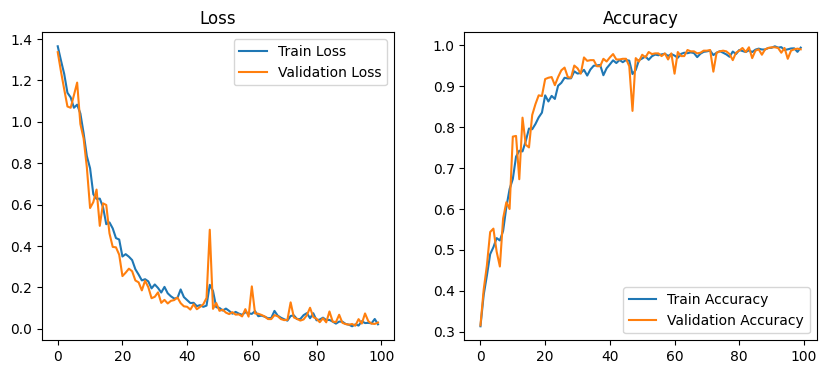

In [ ]:
def show_graphs(history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

show_graphs(history)

In [ ]:
ruta_nuevo_ecg = '/content/N(1).jpeg'

# Llamamos a tu función para obtener el vector del nuevo ECG
# Asegurate de que tu función ecg_to_vector esté definida o importada
try:
    vector_nuevo_ecg = ecg_bw_photo_to_vector(ruta_nuevo_ecg)
    print(f"ECG procesado, longitud del vector: {len(vector_nuevo_ecg)}")
except Exception as e:
    print(f"Error al procesar el ECG: {e}")
    exit()

# --- PASO 3: Preparar el Vector para el model ---
# El model espera una entrada con forma (batch_size, longitud_vector, canales)
# Para una sola predicción, batch_size es 1.
vector_para_predecir = np.array([vector_nuevo_ecg]) # Poner el vector dentro de una lista para crear el batch
vector_para_predecir = vector_para_predecir.reshape(1, vector_para_predecir.shape[1], 1) # Añadir la dimensión del canal

print(f"Forma del vector para predicción: {vector_para_predecir.shape}")

# --- PASO 4: Realizar la Predicción ---
predicciones = model.predict(vector_para_predecir)

# `predicciones` es un array con las probabilidades para cada una de las 4 clases.
# Ejemplo: [[0.1, 0.7, 0.15, 0.05]]

# --- PASO 5: Obtener la Clase Predicha ---
# Encontramos el índice de la clase con la probabilidad más alta
clase_predicha_indice = np.argmax(predicciones[0])
probabilidad_maxima = np.max(predicciones[0])

print("-" * 30)
print(f"Predicción (probabilidades): {predicciones[0]}")
print(f"Índice de Clase Predicha: {clase_predicha_indice}")
print(f"Probabilidad de la clase predicha: {probabilidad_maxima * 100:.2f}%")
print("-" * 30)

ECG procesado, longitud del vector: 2048
Forma del vector para predicción: (1, 2048, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
------------------------------
Predicción (probabilidades): [5.7720696e-04 2.1767383e-04 2.9603386e-04 9.9890912e-01]
Índice de Clase Predicha: 3
Probabilidad de la clase predicha: 99.89%
------------------------------


In [ ]:
model.save("ecg_modelVectorFinal.h5")

In [ ]:
#!git push origin main